In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import random
import imageio.v2 as imageio   # PNG 保存用

# trainをスライス

In [2]:
# ----------------------- 設定 -----------------------
input_base_dir  = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/processed_train"
output_base_dir = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial"
target_cases    = list(range(1003, 1085))

# ------------------- 前処理ループ --------------------
for inp_dir in Path(input_base_dir).glob("inp*"):
    if not inp_dir.is_dir():
        continue
    try:
        case_number = int(inp_dir.name[3:])
    except ValueError:
        continue
    if case_number not in target_cases:
        continue

    folder_results = []

    for vertebra_dir in inp_dir.iterdir():
        if not vertebra_dir.is_dir():
            continue

        annotation_path = vertebra_dir / f"cut_ans{case_number}.nii"
        ct_path         = vertebra_dir / f"cut_inp{case_number}.nii.gz"
        if not annotation_path.exists() or not ct_path.exists():
            continue

        output_dir = Path(output_base_dir) / inp_dir.name / vertebra_dir.name
        output_dir.mkdir(parents=True, exist_ok=True)

        # --- NIfTI 読み込み ---
        ct_img         = nib.load(str(ct_path))
        annotation_img = nib.load(str(annotation_path))
        ct_data        = ct_img.get_fdata()
        annotation_bin = (annotation_img.get_fdata() != 0).astype(np.uint8)

        # --- スライス毎に NIfTI と CSV 情報を作成 ---
        for z in range(ct_data.shape[2]):
            slice_data = ct_data[:, :, z].astype(np.float32)
            has_fract  = bool(annotation_bin[:, :, z].any())
            fracture_label = int(has_fract)

            slice_nifti = nib.Nifti1Image(slice_data, affine=ct_img.affine)
            slice_path  = output_dir / f"slice_{z:03d}.nii"
            nib.save(slice_nifti, str(slice_path))

            folder_results.append({
                "FullPath":     str(slice_path),
                "Vertebra":     vertebra_dir.name,
                "SliceIndex":   z,
                "Fracture_Label": fracture_label,
                "Case":         case_number
            })

    # ---------- CSV 保存 ----------
    df = pd.DataFrame(folder_results)
    csv_path = Path(output_base_dir) / inp_dir.name / f"fracture_labels_{inp_dir.name}.csv"
    df.to_csv(csv_path, index=False)
    print(f"{inp_dir.name} done, csv -> {csv_path}")

print("=== 全ケース処理完了 ===")

inp1003 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/inp1003/fracture_labels_inp1003.csv
inp1017 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/inp1017/fracture_labels_inp1017.csv
inp1021 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/inp1021/fracture_labels_inp1021.csv
inp1027 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/inp1027/fracture_labels_inp1027.csv
inp1035 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/inp1035/fracture_labels_inp1035.csv
inp1038 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/inp1038/fracture_labels_inp1038.csv
inp1043 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/inp1043/fracture_labe

## 可視化

Overlay PNG saved to: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial/overlay_case1049_40_z10.png


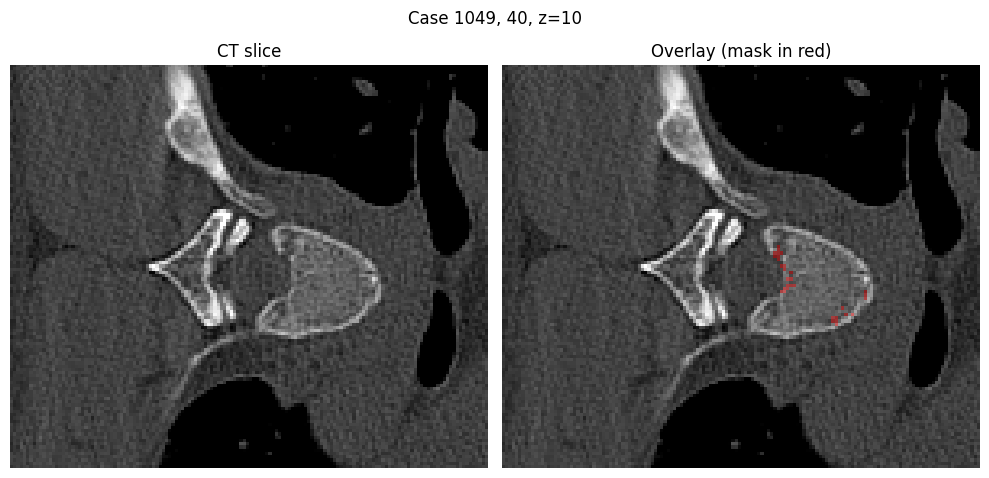

In [3]:
# ------------------- 1 枚だけ可視化 & PNG 保存 --------------------
# --- ここで Path 型にする ---
input_path_dir  = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/processed_train")
output_path_dir = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_train/axial")

csv_files = list(output_path_dir.rglob("fracture_labels_*.csv"))
if not csv_files:
    raise RuntimeError("CSV が見つかりませんでした。前処理に失敗している可能性があります。")

df_all = pd.concat([pd.read_csv(csv) for csv in csv_files], ignore_index=True)
positive = df_all[df_all["Fracture_Label"] == 1]

if positive.empty:
    raise RuntimeError("fracture_label==1 のスライスが見つかりませんでした。")

row = positive.sample(1).iloc[0]                     # ★ ここで 1 枚だけ選択

# --- CT スライス読込 ---
slice_img = nib.load(row.FullPath).get_fdata()

# --- マスク (同じ vertebra ディレクトリの cut_ans*.nii から抽出) ---
mask_path = (
    input_path_dir
    / f"inp{int(row.Case)}"
    / str(row.Vertebra)
    / f"cut_ans{int(row.Case)}.nii"
)
mask_img = nib.load(mask_path).get_fdata()[:, :, int(row.SliceIndex)]
mask_bin = (mask_img != 0)

# --- オーバレイ作成 ---
vmin, vmax = -300, 1100            # 骨用の WL/WW 例
alpha = 0.4
norm  = np.clip((slice_img - vmin) / (vmax - vmin), 0, 1)
gray_rgb = np.stack([norm]*3, axis=-1)
overlay  = gray_rgb.copy()
overlay[mask_bin] = overlay[mask_bin] * (1 - alpha) + np.array([1, 0, 0]) * alpha
overlay_uint8 = (overlay * 255).astype(np.uint8)

# --- PNG 保存（1 枚だけ） ---
png_path = output_path_dir / f"overlay_case{row.Case}_{row.Vertebra}_z{row.SliceIndex}.png"
imageio.imwrite(png_path, overlay_uint8)
print(f"Overlay PNG saved to: {png_path}")

# --- 可視化 ---
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(slice_img, cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title("CT slice")
ax[0].axis('off')
ax[1].imshow(overlay_uint8)
ax[1].set_title("Overlay (mask in red)")
ax[1].axis('off')
plt.suptitle(f"Case {row.Case}, {row.Vertebra}, z={row.SliceIndex}")
plt.tight_layout()
plt.show()

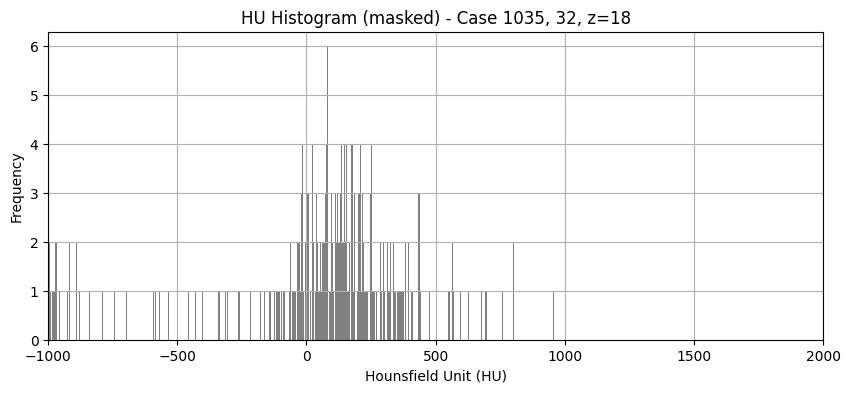

In [9]:
# 対象のスライス（HU値）
slice_hu = slice_img.copy().astype(np.float32)  # HU値そのもの

# マスク領域だけに絞って分布を見る（任意）
masked_hu = slice_hu[mask_bin]

# ヒストグラムプロット
plt.figure(figsize=(10, 4))
plt.hist(masked_hu.flatten(), bins=500, color='gray')
plt.title(f'HU Histogram (masked) - Case {row.Case}, {row.Vertebra}, z={row.SliceIndex}')
plt.xlabel('Hounsfield Unit (HU)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-1000, 2000)  # CTで一般的なHU範囲
plt.show()

/tmp/ipykernel_1101785/146227451.py:28: UserWarning: Glyph 39592 (\N{CJK UNIFIED IDEOGRAPH-9AA8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1101785/146227451.py:28: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1101785/146227451.py:28: UserWarning: Glyph 12316 (\N{WAVE DASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1101785/146227451.py:28: UserWarning: Glyph 36575 (\N{CJK UNIFIED IDEOGRAPH-8EDF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1101785/146227451.py:28: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


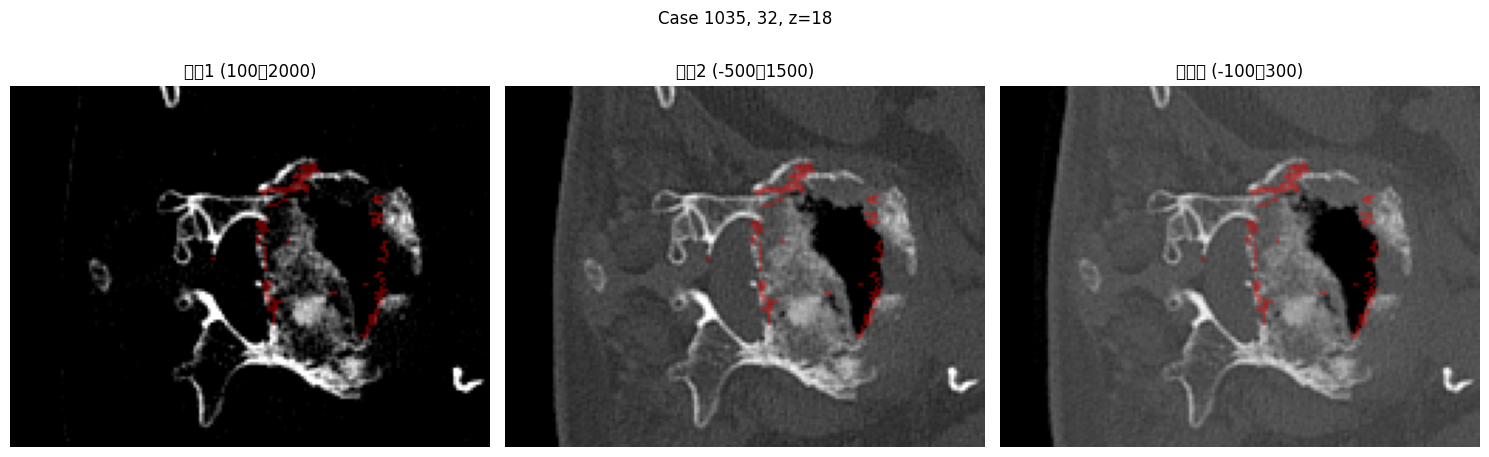

In [11]:
# 1. パターン定義（WL/WW に相当）
window_settings = [
    {"label": "骨用1 (100〜2000)", "vmin": 100, "vmax": 1100},
    {"label": "骨用2 (-500〜1500)",  "vmin": -500, "vmax": 1500},
    {"label": "軟部用 (-100〜300)",  "vmin": -750, "vmax": 1750},
]

alpha = 0.4

fig, axes = plt.subplots(1, len(window_settings), figsize=(15, 5))
for ax, ws in zip(axes, window_settings):
    vmin, vmax = ws["vmin"], ws["vmax"]

    # CT スケーリング
    norm = np.clip((slice_img - vmin) / (vmax - vmin), 0, 1)
    gray_rgb = np.stack([norm]*3, axis=-1)

    # マスクオーバレイ
    overlay = gray_rgb.copy()
    overlay[mask_bin] = overlay[mask_bin] * (1 - alpha) + np.array([1, 0, 0]) * alpha
    overlay_uint8 = (overlay * 255).astype(np.uint8)

    ax.imshow(overlay_uint8)
    ax.set_title(ws["label"])
    ax.axis('off')

plt.suptitle(f"Case {row.Case}, {row.Vertebra}, z={row.SliceIndex}")
plt.tight_layout()
plt.show()


# valをスライス

In [4]:
# ----------------------- 設定 -----------------------
input_base_dir  = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/processed_val"
output_base_dir = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial"
target_cases    = list(range(1003, 1085))

# ------------------- 前処理ループ --------------------
for inp_dir in Path(input_base_dir).glob("inp*"):
    if not inp_dir.is_dir():
        continue
    try:
        case_number = int(inp_dir.name[3:])
    except ValueError:
        continue
    if case_number not in target_cases:
        continue

    folder_results = []

    for vertebra_dir in inp_dir.iterdir():
        if not vertebra_dir.is_dir():
            continue

        annotation_path = vertebra_dir / f"cut_ans{case_number}.nii"
        ct_path         = vertebra_dir / f"cut_inp{case_number}.nii.gz"
        if not annotation_path.exists() or not ct_path.exists():
            continue

        output_dir = Path(output_base_dir) / inp_dir.name / vertebra_dir.name
        output_dir.mkdir(parents=True, exist_ok=True)

        # --- NIfTI 読み込み ---
        ct_img         = nib.load(str(ct_path))
        annotation_img = nib.load(str(annotation_path))
        ct_data        = ct_img.get_fdata()
        annotation_bin = (annotation_img.get_fdata() != 0).astype(np.uint8)

        # --- スライス毎に NIfTI と CSV 情報を作成 ---
        for z in range(ct_data.shape[2]):
            slice_data = ct_data[:, :, z].astype(np.float32)
            has_fract  = bool(annotation_bin[:, :, z].any())
            fracture_label = int(has_fract)

            slice_nifti = nib.Nifti1Image(slice_data, affine=ct_img.affine)
            slice_path  = output_dir / f"slice_{z:03d}.nii"
            nib.save(slice_nifti, str(slice_path))

            folder_results.append({
                "FullPath":     str(slice_path),
                "Vertebra":     vertebra_dir.name,
                "SliceIndex":   z,
                "Fracture_Label": fracture_label,
                "Case":         case_number
            })

    # ---------- CSV 保存 ----------
    df = pd.DataFrame(folder_results)
    csv_path = Path(output_base_dir) / inp_dir.name / f"fracture_labels_{inp_dir.name}.csv"
    df.to_csv(csv_path, index=False)
    print(f"{inp_dir.name} done, csv -> {csv_path}")

print("=== 全ケース処理完了 ===")

inp1010 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial/inp1010/fracture_labels_inp1010.csv
inp1015 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial/inp1015/fracture_labels_inp1015.csv
inp1016 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial/inp1016/fracture_labels_inp1016.csv
inp1030 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial/inp1030/fracture_labels_inp1030.csv
inp1052 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial/inp1052/fracture_labels_inp1052.csv
inp1073 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial/inp1073/fracture_labels_inp1073.csv
=== 全ケース処理完了 ===


## 可視化

In [ ]:
# ------------------- 1 枚だけ可視化 & PNG 保存 --------------------
# --- ここで Path 型にする ---
input_path_dir  = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/processed_val")
output_path_dir = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_val/axial")

csv_files = list(output_path_dir.rglob("fracture_labels_*.csv"))
if not csv_files:
    raise RuntimeError("CSV が見つかりませんでした。前処理に失敗している可能性があります。")

df_all = pd.concat([pd.read_csv(csv) for csv in csv_files], ignore_index=True)
positive = df_all[df_all["Fracture_Label"] == 1]

if positive.empty:
    raise RuntimeError("fracture_label==1 のスライスが見つかりませんでした。")

row = positive.sample(1).iloc[0]                     # ★ ここで 1 枚だけ選択

# --- CT スライス読込 ---
slice_img = nib.load(row.FullPath).get_fdata()

# --- マスク (同じ vertebra ディレクトリの cut_ans*.nii から抽出) ---
mask_path = (
    input_path_dir
    / f"inp{int(row.Case)}"
    / str(row.Vertebra)
    / f"cut_ans{int(row.Case)}.nii"
)
mask_img = nib.load(mask_path).get_fdata()[:, :, int(row.SliceIndex)]
mask_bin = (mask_img != 0)

# --- オーバレイ作成 ---
vmin, vmax = -300, 800            # 骨用の WL/WW 例
alpha = 0.4
norm  = np.clip((slice_img - vmin) / (vmax - vmin), 0, 1)
gray_rgb = np.stack([norm]*3, axis=-1)
overlay  = gray_rgb.copy()
overlay[mask_bin] = overlay[mask_bin] * (1 - alpha) + np.array([1, 0, 0]) * alpha
overlay_uint8 = (overlay * 255).astype(np.uint8)

In [15]:
# --- PNG 保存（1 枚だけ） ---
png_path = output_path_dir / f"overlay_case{row.Case}_{row.Vertebra}_z{row.SliceIndex}.png"
imageio.imwrite(png_path, overlay_uint8)
print(f"Overlay PNG saved to: {png_path}")

Overlay PNG saved to: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_val/axial/overlay_case1012_31_z24.png


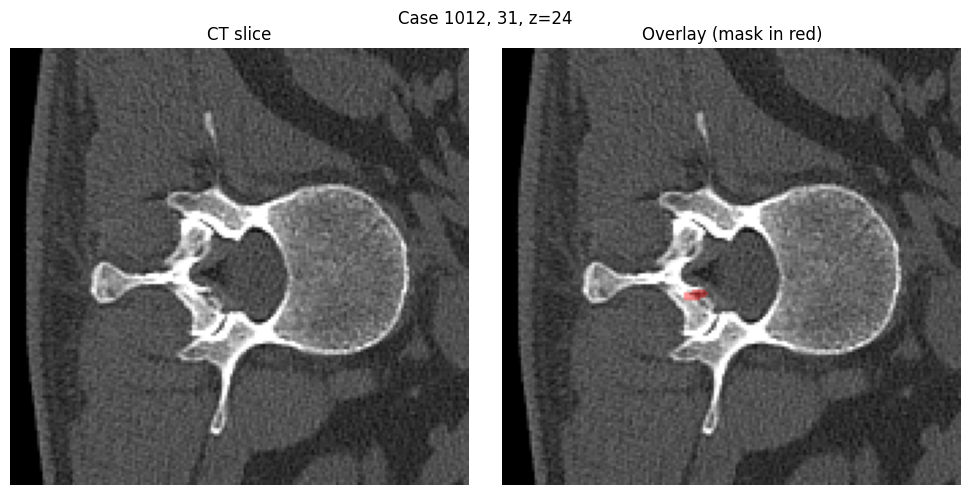

In [16]:
# --- 可視化 ---
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(slice_img, cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title("CT slice")
ax[0].axis('off')
ax[1].imshow(overlay_uint8)
ax[1].set_title("Overlay (mask in red)")
ax[1].axis('off')
plt.suptitle(f"Case {row.Case}, {row.Vertebra}, z={row.SliceIndex}")
plt.tight_layout()
plt.show()

# testをスライス

In [5]:
# ----------------------- 設定 -----------------------
input_base_dir  = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/processed_test"
output_base_dir = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial"
target_cases    = list(range(1003, 1085))

# ------------------- 前処理ループ --------------------
for inp_dir in Path(input_base_dir).glob("inp*"):
    if not inp_dir.is_dir():
        continue
    try:
        case_number = int(inp_dir.name[3:])
    except ValueError:
        continue
    if case_number not in target_cases:
        continue

    folder_results = []

    for vertebra_dir in inp_dir.iterdir():
        if not vertebra_dir.is_dir():
            continue

        annotation_path = vertebra_dir / f"cut_ans{case_number}.nii"
        ct_path         = vertebra_dir / f"cut_inp{case_number}.nii.gz"
        if not annotation_path.exists() or not ct_path.exists():
            continue

        output_dir = Path(output_base_dir) / inp_dir.name / vertebra_dir.name
        output_dir.mkdir(parents=True, exist_ok=True)

        # --- NIfTI 読み込み ---
        ct_img         = nib.load(str(ct_path))
        annotation_img = nib.load(str(annotation_path))
        ct_data        = ct_img.get_fdata()
        annotation_bin = (annotation_img.get_fdata() != 0).astype(np.uint8)

        # --- スライス毎に NIfTI と CSV 情報を作成 ---
        for z in range(ct_data.shape[2]):
            slice_data = ct_data[:, :, z].astype(np.float32)
            has_fract  = bool(annotation_bin[:, :, z].any())
            fracture_label = int(has_fract)

            slice_nifti = nib.Nifti1Image(slice_data, affine=ct_img.affine)
            slice_path  = output_dir / f"slice_{z:03d}.nii"
            nib.save(slice_nifti, str(slice_path))

            folder_results.append({
                "FullPath":     str(slice_path),
                "Vertebra":     vertebra_dir.name,
                "SliceIndex":   z,
                "Fracture_Label": fracture_label,
                "Case":         case_number
            })

    # ---------- CSV 保存 ----------
    df = pd.DataFrame(folder_results)
    csv_path = Path(output_base_dir) / inp_dir.name / f"fracture_labels_{inp_dir.name}.csv"
    df.to_csv(csv_path, index=False)
    print(f"{inp_dir.name} done, csv -> {csv_path}")

print("=== 全ケース処理完了 ===")

inp1012 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial/inp1012/fracture_labels_inp1012.csv
inp1025 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial/inp1025/fracture_labels_inp1025.csv
inp1039 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial/inp1039/fracture_labels_inp1039.csv
inp1051 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial/inp1051/fracture_labels_inp1051.csv
inp1069 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial/inp1069/fracture_labels_inp1069.csv
inp1075 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial/inp1075/fracture_labels_inp1075.csv
inp1080 done, csv -> /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file/slice_test/axial/inp1080/fracture_labels_inp1

## 可視化

Overlay PNG saved to: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_test/axial/overlay_case1015_31_z144.png


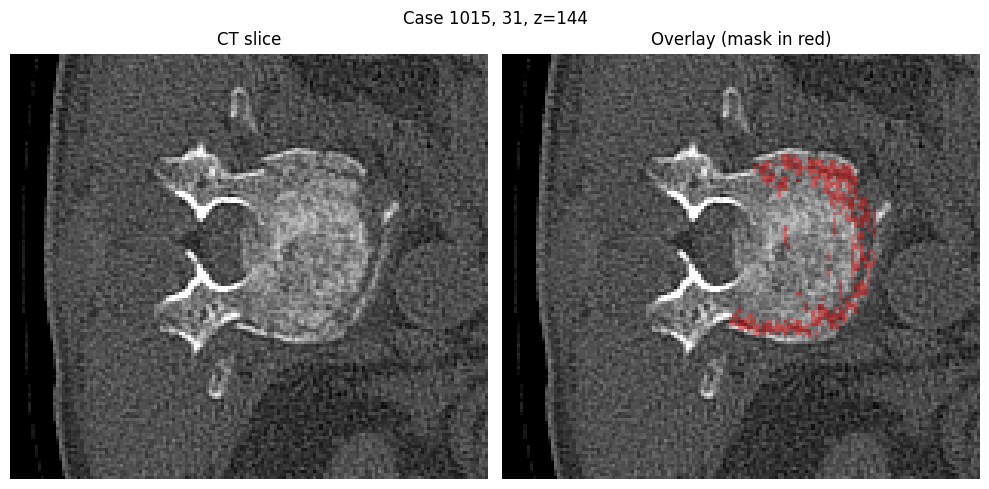

In [13]:
# ------------------- 1 枚だけ可視化 & PNG 保存 --------------------
# --- ここで Path 型にする ---
input_path_dir  = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/processed_test")
output_path_dir = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_test/axial")

csv_files = list(output_path_dir.rglob("fracture_labels_*.csv"))
if not csv_files:
    raise RuntimeError("CSV が見つかりませんでした。前処理に失敗している可能性があります。")

df_all = pd.concat([pd.read_csv(csv) for csv in csv_files], ignore_index=True)
positive = df_all[df_all["Fracture_Label"] == 1]

if positive.empty:
    raise RuntimeError("fracture_label==1 のスライスが見つかりませんでした。")

row = positive.sample(1).iloc[0]                     # ★ ここで 1 枚だけ選択

# --- CT スライス読込 ---
slice_img = nib.load(row.FullPath).get_fdata()

# --- マスク (同じ vertebra ディレクトリの cut_ans*.nii から抽出) ---
mask_path = (
    input_path_dir
    / f"inp{int(row.Case)}"
    / str(row.Vertebra)
    / f"cut_ans{int(row.Case)}.nii"
)
mask_img = nib.load(mask_path).get_fdata()[:, :, int(row.SliceIndex)]
mask_bin = (mask_img != 0)

# --- オーバレイ作成 ---
vmin, vmax = -300, 800            # 骨用の WL/WW 例
alpha = 0.4
norm  = np.clip((slice_img - vmin) / (vmax - vmin), 0, 1)
gray_rgb = np.stack([norm]*3, axis=-1)
overlay  = gray_rgb.copy()
overlay[mask_bin] = overlay[mask_bin] * (1 - alpha) + np.array([1, 0, 0]) * alpha
overlay_uint8 = (overlay * 255).astype(np.uint8)

# --- PNG 保存（1 枚だけ） ---
png_path = output_path_dir / f"overlay_case{row.Case}_{row.Vertebra}_z{row.SliceIndex}.png"
imageio.imwrite(png_path, overlay_uint8)
print(f"Overlay PNG saved to: {png_path}")

# --- 可視化 ---
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(slice_img, cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title("CT slice")
ax[0].axis('off')
ax[1].imshow(overlay_uint8)
ax[1].set_title("Overlay (mask in red)")
ax[1].axis('off')
plt.suptitle(f"Case {row.Case}, {row.Vertebra}, z={row.SliceIndex}")
plt.tight_layout()
plt.show()